In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [3]:
OUT_DIM=6

In [4]:
path = Path("./activations")

In [76]:
img_files = get_files(path/"img"); img_files

(#359882) [Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_783154_3660743_1420_09102014_1.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1012920_310814938_1420_01122016_27.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_822006_4778600_1420_19062014_3.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_299.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_821707_4770044_1420_19062014_4.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_288.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1019716_311062360_1420_17012017_15.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1062700_312268503_1420_21072017_6.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_248.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1019823_3

In [6]:
text_files = get_files(path/"text"); text_files

(#326037) [Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1075473_312738372_1420_14092017_6.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1054017_311988070_1420_08062017_7.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1082106_312930948_1420_10102017_15.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1087577_313124642_1420_26102017_6.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1000611_310414607_1420_01102016_14.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1075473_312738372_1420_14092017_7.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1062700_312268503_1420_21072017_4.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_941848_308456398_1420_14012016_3.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_941656_308447674_1420_12012016_11.npy'),Path('activations/text/val/agravo_em_recurso_extraor

In [7]:
text_set = set([t.with_suffix("").name for t in text_files])

In [8]:
img_set = set([t.with_suffix("").name for t in img_files])

In [9]:
len(text_set), len(img_set)

(326037, 359882)

In [10]:
img_and_text = text_set.intersection(text_set, img_set); len(img_and_text)

326033

In [11]:
just_img = img_set - text_set; len(just_img)

33849

In [12]:
just_text = text_set - img_set; len(just_text)

4

In [130]:
train_csv = pd.read_csv("./data/train_fusion.csv")
val_csv = pd.read_csv("./data/val_fusion.csv")
test_csv = pd.read_csv("./data/test_fusion.csv")

In [131]:
train_csv["is_valid"] = False
val_csv["is_valid"] = True
data = pd.concat([train_csv, val_csv])

In [132]:
data["has_text"] = True

In [133]:
data["has_image"]= ~(data["file_name"].str.slice(stop=-4) + "_" + data["pages"].astype(str)).isin(just_text)

In [ ]:
data.head(1)

In [77]:
just_imgs = [x for x in img_files if x.with_suffix("").name in just_img]; len(just_imgs), just_imgs[:3]

(33849,
 [Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_299.pt'),
  Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_288.pt'),
  Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_248.pt')])

In [136]:
just_imgs[0].with_suffix("").as_posix()

'activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_299'

In [137]:
just_imgs_dics = []
for p in tqdm(just_imgs):
    parts = p.parts
    if parts[2] == "test":
        continue
    dic = {}
    dic["process_id"] = re.search(r"[^_]*_\d+",parts[4])[0]
    dic["file_name"] = parts[4][:-2] + "pdf"
    dic["document_type"] = parts[3]
    dic["pages"] = re.search(r"(?<=_)\d+(?=\.pt)", parts[4])[0]
    dic["is_valid"] = parts[2] == "val"
    dic["has_text"] = False
    dic["has_image"] = True
    dic["activation_path"] = p.with_suffix("").as_posix()
    just_imgs_dics.append(dic)

In [138]:
just_imgs_df = pd.DataFrame(just_imgs_dics, columns = data.columns); just_imgs_df.head()

,themes,process_id,file_name,document_type,pages,body,activation_path,is_valid,has_text,has_image
0,NaN,ARE_1053618,ARE_1053618_311977154_1420_07062017_299.pdf,agravo_em_recurso_extraordinario,299,NaN,activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_299,True,False,True
1,NaN,ARE_1053618,ARE_1053618_311977154_1420_07062017_288.pdf,agravo_em_recurso_extraordinario,288,NaN,activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_288,True,False,True
2,NaN,ARE_1053618,ARE_1053618_311977154_1420_07062017_248.pdf,agravo_em_recurso_extraordinario,248,NaN,activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_248,True,False,True
3,NaN,ARE_1064575,ARE_1064575_312350997_1420_03082017_54.pdf,agravo_em_recurso_extraordinario,54,NaN,activations/img/val/agravo_em_recurso_extraordinario/ARE_1064575_312350997_1420_03082017_54,True,False,True
4,NaN,ARE_1073427,ARE_1073427_312673900_1420_05092017_41.pdf,agravo_em_recurso_extraordinario,41,NaN,activations/img/val/agravo_em_recurso_extraordinario/ARE_1073427_312673900_1420_05092017_41,True,False,True


In [139]:
data = pd.concat([data, just_imgs_df])

In [ ]:
data.head(1)

In [140]:
data.tail()

,themes,process_id,file_name,document_type,pages,body,activation_path,is_valid,has_text,has_image
25807,NaN,RE_1054472,RE_1054472_311999156_12_16062017_15.pdf,peticao_do_RE,15,NaN,activations/img/train/peticao_do_RE/RE_1054472_311999156_12_16062017_15,False,False,True
25808,NaN,AI_856934,AI_856934_1926217_12_17072013_47.pdf,peticao_do_RE,47,NaN,activations/img/train/peticao_do_RE/AI_856934_1926217_12_17072013_47,False,False,True
25809,NaN,RE_1054472,RE_1054472_311999156_12_16062017_162.pdf,peticao_do_RE,162,NaN,activations/img/train/peticao_do_RE/RE_1054472_311999156_12_16062017_162,False,False,True
25810,NaN,RE_1054472,RE_1054472_311999156_12_16062017_27.pdf,peticao_do_RE,27,NaN,activations/img/train/peticao_do_RE/RE_1054472_311999156_12_16062017_27,False,False,True
25811,NaN,RE_1054472,RE_1054472_311999157_12_10062017_85.pdf,peticao_do_RE,85,NaN,activations/img/train/peticao_do_RE/RE_1054472_311999157_12_10062017_85,False,False,True


In [118]:
img_files

(#359882) [Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_783154_3660743_1420_09102014_1.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1012920_310814938_1420_01122016_27.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_822006_4778600_1420_19062014_3.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_299.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_821707_4770044_1420_19062014_4.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_288.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1019716_311062360_1420_17012017_15.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1062700_312268503_1420_21072017_6.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_248.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1019823_3

In [171]:
class GetActs(Transform):
    def encodes(self, x):        
        img_file = text_file = None
        
        if x["has_text"]:
            text_file = Path(x["activation_path"] + ".npy")
            if x["has_image"]:
                img_file = Path(text_file.as_posix().replace("text", "img").replace("npy", "pt"))
        else:
            img_file = Path(x["activation_path"] + ".pt")
        
        if img_file is None:
            img_act = torch.zeros((4096))
        else:
            img_act = torch.load(img_file)
                            
        if text_file is None:
            text_act = torch.zeros((3840))
            text_none = True
        else:
            text_act = tensor(np.load(text_file))
        
        img_none = img_file == None
        text_none = text_file == None
                            
        return (img_act, text_act, img_none, text_none)

In [172]:
tfms = [[GetActs()], [ColReader("document_type"), Categorize()]]
splits = ColSplitter()(data)
dsets = Datasets(data, tfms, splits=splits)
dls = dsets.dataloaders()

In [173]:
dls.train_ds, dls.valid_ds

((#162187) [((TensorImage([3.7440, 1.8218, 4.8144,  ..., 0.6569, 1.0708, 0.1497]), tensor([0.8860, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]), False, False), TensorCategory(3)),((TensorImage([3.7186, 1.4871, 3.9594,  ..., 0.8080, 0.4135, 0.4271]), tensor([0.8802, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]), False, False), TensorCategory(3)),((TensorImage([3.9172, 1.6114, 4.4490,  ..., 0.8543, 0.4038, 0.3799]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), False, False), TensorCategory(3)),((TensorImage([2.9024, 1.0994, 3.7002,  ..., 0.6721, 0.0640, 0.9441]), tensor([0.5176, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]), False, False), TensorCategory(3)),((TensorImage([2.2220, 1.6094, 5.0237,  ..., 0.9245, 0.3397, 0.4138]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), False, False), TensorCategory(3)),((TensorImage([2.4088, 1.0029, 6.2333,  ..., 1.3033, 0.4426, 0.6164]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), False, False), TensorCategory(3)),((TensorImage([3.3910, 1.7982, 4.7816,  ..., 1

In [174]:
torch.save(dls, "./data/fusion_dl_v2.pth")

In [175]:
class ImgTextFusion(Module):
    def __init__(self, head, embs_for_none=True, img_emb_dim=4096, text_emb_dim=3840):
        self.head = head.cuda()
        self.embs_for_none = embs_for_none
        if embs_for_none:
            self.img_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=img_emb_dim).cuda()
            self.text_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=text_emb_dim).cuda()
            self.index= tensor(0).cuda()
    
    def forward(self, x):
        img_act, text_act, img_none, text_none = x
        if self.embs_for_none:
            img_act[img_none] = self.img_none_emb(self.index)
            text_act[text_none] = self.text_none_emb(self.index)
        return self.head(torch.cat([img_act, text_act], axis=-1))

In [176]:
def create_head(nf, n_out, lin_ftrs=None, ps=0.5, bn_final=False, lin_first=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and out `n_out` classes."
    lin_ftrs = [nf, 512, n_out] if lin_ftrs is None else [nf] + lin_ftrs + [n_out]
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += LinBnDrop(ni, no, bn=True, p=p, act=actn, lin_first=lin_first)
    if lin_first: layers.append(nn.Linear(lin_ftrs[-2], n_out))
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

In [177]:
head = create_head(4096 + 3840, OUT_DIM)

In [178]:
model = ImgTextFusion(head)

In [179]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [180]:
fscore = F1Score(average='macro')

In [181]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [182]:
learn.summary()

ImgTextFusion (Input shape: ["['64 x 4096', '64 x 3840', '64', '64']"])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 7936            15,872     True      
________________________________________________________________
Dropout              64 x 7936            0          False     
________________________________________________________________
Linear               64 x 512             4,063,232  True      
________________________________________________________________
ReLU                 64 x 512             0          False     
________________________________________________________________
BatchNorm1d          64 x 512             1,024      True      
________________________________________________________________
Dropout              64 x 512             0          False     
________________________________________________________________
Linear               64 x 6               3,072      True      
__________________________

In [183]:
learn.validate()

(#3) [1.6943942308425903,0.09466707706451416,0.03669096179894526]

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.2089296132326126)

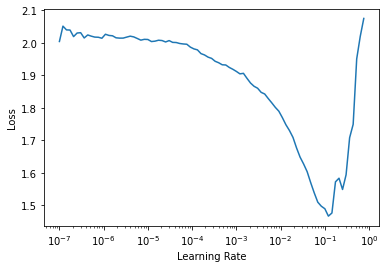

In [184]:
learn.lr_find()

In [185]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.128080,0.376940,0.930515,0.673239,22:10
1,0.259625,4.643151,0.935628,0.593583,17:35
2,0.259196,7.071113,0.934679,0.564520,16:09
3,0.194966,20.239988,0.924445,0.588218,14:37
4,0.214672,3.702258,0.930664,0.701053,13:59
5,0.153157,1.452543,0.935525,0.654564,13:26
6,0.116569,0.977983,0.936185,0.688334,14:41
7,0.091932,5.964290,0.927522,0.712456,14:30
8,0.074515,1.087495,0.936139,0.731367,13:43
9,0.079861,2.625897,0.936613,0.738508,12:44


Better model found at epoch 0 with f1_score value: 0.6732394603330469.


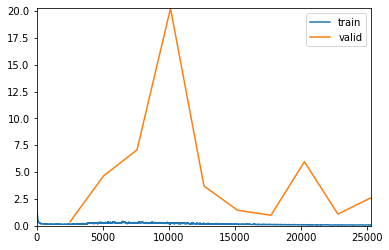

Better model found at epoch 4 with f1_score value: 0.7010530291305989.
Better model found at epoch 7 with f1_score value: 0.7124561589622583.
Better model found at epoch 8 with f1_score value: 0.7313674419110675.
Better model found at epoch 9 with f1_score value: 0.7385077177764918.


In [186]:
learn.fit_one_cycle(10, lr_max=5e-2)

In [187]:
head = create_head(4096 + 3840, OUT_DIM, lin_ftrs=[128])

In [188]:
model = ImgTextFusion(head)

In [189]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [190]:
learn.summary()

ImgTextFusion (Input shape: ["['64 x 4096', '64 x 3840', '64', '64']"])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 7936            15,872     True      
________________________________________________________________
Dropout              64 x 7936            0          False     
________________________________________________________________
Linear               64 x 128             1,015,808  True      
________________________________________________________________
ReLU                 64 x 128             0          False     
________________________________________________________________
BatchNorm1d          64 x 128             256        True      
________________________________________________________________
Dropout              64 x 128             0          False     
________________________________________________________________
Linear               64 x 6               768        True      
__________________________

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.04786301031708717)

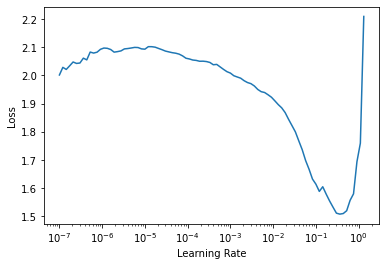

In [191]:
learn.lr_find()

In [192]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion_128'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.114972,0.332803,0.931426,0.645706,13:49
1,0.163148,1.714100,0.938323,0.715122,13:59
2,0.170105,0.599583,0.935544,0.685921,12:05
3,0.169546,0.417187,0.939903,0.721484,12:33
4,0.131899,0.387624,0.927633,0.683539,14:18
5,0.121839,0.362846,0.934782,0.740932,13:04
6,0.106399,0.323559,0.935655,0.734617,12:13
7,0.091403,0.321372,0.940452,0.750716,14:15
8,0.076669,0.342724,0.935581,0.751590,12:49
9,0.071246,0.339889,0.935562,0.752328,11:37


Better model found at epoch 0 with f1_score value: 0.6457063643963779.


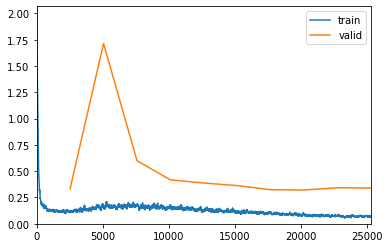

Better model found at epoch 1 with f1_score value: 0.7151217600878655.
Better model found at epoch 3 with f1_score value: 0.7214844427664984.
Better model found at epoch 5 with f1_score value: 0.7409323321314533.
Better model found at epoch 7 with f1_score value: 0.7507155787127314.
Better model found at epoch 8 with f1_score value: 0.7515901577508828.
Better model found at epoch 9 with f1_score value: 0.7523279263195454.


In [193]:
learn.fit_one_cycle(10, lr_max=5e-2)

In [194]:
head = create_head(4096 + 3840, OUT_DIM, lin_ftrs=[128])

In [195]:
model = ImgTextFusion(head, embs_for_none=False)

In [196]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [197]:
learn.summary()

ImgTextFusion (Input shape: ["['64 x 4096', '64 x 3840', '64', '64']"])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 7936            15,872     True      
________________________________________________________________
Dropout              64 x 7936            0          False     
________________________________________________________________
Linear               64 x 128             1,015,808  True      
________________________________________________________________
ReLU                 64 x 128             0          False     
________________________________________________________________
BatchNorm1d          64 x 128             256        True      
________________________________________________________________
Dropout              64 x 128             0          False     
________________________________________________________________
Linear               64 x 6               768        True      
__________________________

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.03981071710586548)

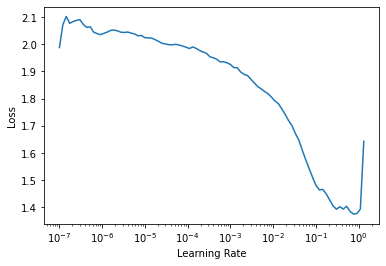

In [198]:
learn.lr_find()

In [199]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion_zeros_128'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.110151,0.338478,0.938240,0.694480,13:15
1,0.148982,41.343945,0.911403,0.659699,13:19
2,0.155948,215.246307,0.927122,0.680936,10:55
3,0.137429,362.502319,0.934057,0.632382,13:12
4,0.145068,7.358563,0.921080,0.667720,13:02
5,0.127022,23.239586,0.928507,0.704048,10:28
6,0.101358,42.332283,0.931268,0.670323,13:17
7,0.084311,99.997772,0.936278,0.687305,10:26
8,0.077231,104.628609,0.926964,0.671258,12:58
9,0.073783,52.623348,0.929725,0.672483,10:11


Better model found at epoch 0 with f1_score value: 0.6944795091884797.


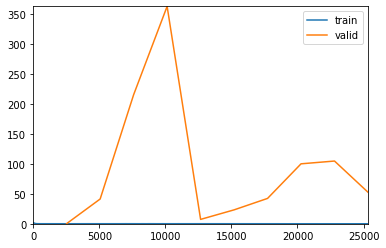

Better model found at epoch 5 with f1_score value: 0.7040480614849526.


In [200]:
learn.fit_one_cycle(10, lr_max=5e-2)

In [201]:
head = create_head(4096 + 3840, OUT_DIM)

In [202]:
model = ImgTextFusion(head, embs_for_none=False)

In [203]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [204]:
learn.summary()

ImgTextFusion (Input shape: ["['64 x 4096', '64 x 3840', '64', '64']"])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 7936            15,872     True      
________________________________________________________________
Dropout              64 x 7936            0          False     
________________________________________________________________
Linear               64 x 512             4,063,232  True      
________________________________________________________________
ReLU                 64 x 512             0          False     
________________________________________________________________
BatchNorm1d          64 x 512             1,024      True      
________________________________________________________________
Dropout              64 x 512             0          False     
________________________________________________________________
Linear               64 x 6               3,072      True      
__________________________

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.02754228748381138)

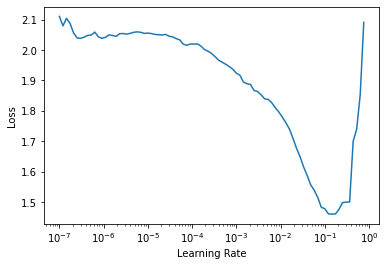

In [205]:
learn.lr_find()

In [206]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion_zeros'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.134407,0.431868,0.899328,0.670404,12:37
1,0.153378,19.850607,0.925718,0.575709,09:50
2,0.166216,17.007902,0.924826,0.653437,12:29
3,0.147412,123.811996,0.926750,0.624076,11:24
4,0.139108,507.357300,0.929994,0.620347,14:04
5,0.130705,106.909302,0.923078,0.613028,14:31
6,0.098014,27.732090,0.931547,0.651369,10:02
7,0.075739,59.757435,0.936120,0.692833,08:52
8,0.077210,14.266563,0.932681,0.696128,08:45
9,0.068784,5.813344,0.932829,0.699519,08:20


Better model found at epoch 0 with f1_score value: 0.6704040866291474.


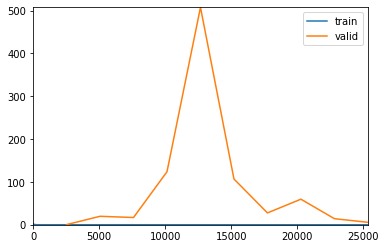

Better model found at epoch 7 with f1_score value: 0.6928334520070548.
Better model found at epoch 8 with f1_score value: 0.6961284391067014.
Better model found at epoch 9 with f1_score value: 0.6995193607126686.


In [207]:
learn.fit_one_cycle(10, lr_max=3e-2)

In [208]:
head = create_head(4096 + 3840, OUT_DIM, lin_ftrs=[128])

In [209]:
model = ImgTextFusion(head)

In [210]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [211]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion_128_moreEpochs'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.108838,0.281479,0.938807,0.719683,08:37
1,0.103109,0.315590,0.932802,0.735200,08:28
2,0.144701,0.327670,0.929334,0.724216,08:20
3,0.155421,0.370504,0.935925,0.702918,08:14
4,0.180047,0.412570,0.929994,0.730276,08:04
5,0.153721,0.353987,0.929065,0.740265,08:05
6,0.158610,0.426841,0.932077,0.672284,07:55
7,0.155424,0.378475,0.930757,0.635073,07:55
8,0.136670,0.346045,0.940071,0.736008,07:56
9,0.126189,0.381415,0.935181,0.736491,07:54


Better model found at epoch 0 with f1_score value: 0.7196832402720789.


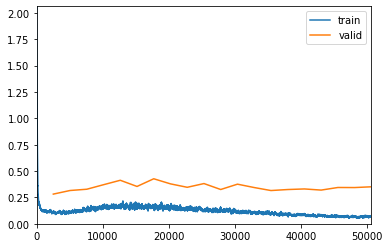

Better model found at epoch 1 with f1_score value: 0.7352004320513926.
Better model found at epoch 5 with f1_score value: 0.7402651371326378.
Better model found at epoch 10 with f1_score value: 0.745378085739771.
Better model found at epoch 16 with f1_score value: 0.7566834483586823.


In [212]:
learn.fit_one_cycle(20, lr_max=5e-2)

In [213]:
from utils import evaluate

In [214]:
learn.load("best_fusion_128_moreEpochs")

In [215]:
from sklearn.metrics import classification_report

preds, targets = learn.get_preds()
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.8691    0.7469    0.8034       320
agravo_em_recurso_extraordinario     0.6668    0.4407    0.5307      2798
     despacho_de_admissibilidade     0.8788    0.6138    0.7227       189
                          outros     0.9553    0.9828    0.9689     95602
                   peticao_do_RE     0.8025    0.6518    0.7193      6987
                        sentenca     0.9149    0.7032    0.7952      1681

                        accuracy                         0.9415    107577
                       macro avg     0.8479    0.6898    0.7567    107577
                    weighted avg     0.9369    0.9415    0.9376    107577



In [222]:
test_csv["has_text"] = True

In [223]:
test_csv["has_image"]= ~(test_csv["file_name"].str.slice(stop=-4) + "_" + test_csv["pages"].astype(str)).isin(just_text)

In [228]:
just_imgs_dics_test = []
for p in tqdm(just_imgs):
    parts = p.parts
    if parts[2] != "test":
        continue
    dic = {}
    dic["process_id"] = re.search(r"[^_]*_\d+",parts[4])[0]
    dic["file_name"] = parts[4][:-2] + "pdf"
    dic["document_type"] = parts[3]
    dic["pages"] = re.search(r"(?<=_)\d+(?=\.pt)", parts[4])[0]
    dic["has_text"] = False
    dic["has_image"] = True
    dic["activation_path"] = p.with_suffix("").as_posix()
    just_imgs_dics_test.append(dic)

In [229]:
just_imgs_df_test = pd.DataFrame(just_imgs_dics_test, columns = data.columns); just_imgs_df_test.head()

,themes,process_id,file_name,document_type,pages,body,activation_path,is_valid,has_text,has_image
0,NaN,ARE_1078603,ARE_1078603_312827755_1420_25092017_217.pdf,agravo_em_recurso_extraordinario,217,NaN,activations/img/test/agravo_em_recurso_extraordinario/ARE_1078603_312827755_1420_25092017_217,NaN,False,True
1,NaN,ARE_1099482,ARE_1099482_313471667_1420_11122017_46.pdf,agravo_em_recurso_extraordinario,46,NaN,activations/img/test/agravo_em_recurso_extraordinario/ARE_1099482_313471667_1420_11122017_46,NaN,False,True
2,NaN,ARE_1060558,ARE_1060558_312197391_1420_30082017_51.pdf,agravo_em_recurso_extraordinario,51,NaN,activations/img/test/agravo_em_recurso_extraordinario/ARE_1060558_312197391_1420_30082017_51,NaN,False,True
3,NaN,ARE_1060551,ARE_1060551_312197210_1420_10072017_56.pdf,agravo_em_recurso_extraordinario,56,NaN,activations/img/test/agravo_em_recurso_extraordinario/ARE_1060551_312197210_1420_10072017_56,NaN,False,True
4,NaN,ARE_1078603,ARE_1078603_312827755_1420_25092017_123.pdf,agravo_em_recurso_extraordinario,123,NaN,activations/img/test/agravo_em_recurso_extraordinario/ARE_1078603_312827755_1420_25092017_123,NaN,False,True


In [232]:
test_data = pd.concat([test_csv, just_imgs_df_test])

In [235]:
test_data.tail()

,themes,process_id,file_name,document_type,pages,body,activation_path,has_text,has_image,is_valid
8032,NaN,ARE_1130738,ARE_1130738_314300437_12_08052018_79.pdf,peticao_do_RE,79,NaN,activations/img/test/peticao_do_RE/ARE_1130738_314300437_12_08052018_79,False,True,NaN
8033,NaN,ARE_721616,ARE_721616_2218683_12_26072013_15.pdf,peticao_do_RE,15,NaN,activations/img/test/peticao_do_RE/ARE_721616_2218683_12_26072013_15,False,True,NaN
8034,NaN,ARE_1062698,ARE_1062698_312268390_12_27072017_22.pdf,peticao_do_RE,22,NaN,activations/img/test/peticao_do_RE/ARE_1062698_312268390_12_27072017_22,False,True,NaN
8035,NaN,ARE_1062698,ARE_1062698_312268390_12_27072017_19.pdf,peticao_do_RE,19,NaN,activations/img/test/peticao_do_RE/ARE_1062698_312268390_12_27072017_19,False,True,NaN
8036,NaN,ARE_1064565,ARE_1064565_312350506_12_03082017_31.pdf,peticao_do_RE,31,NaN,activations/img/test/peticao_do_RE/ARE_1064565_312350506_12_03082017_31,False,True,NaN


In [236]:
test_dl = dls.test_dl(test_data, with_labels=True)

In [265]:
img_test_data = test_data[test_data["has_image"]==True].drop_duplicates("activation_path"); len(img_test_data)

98577

In [266]:
img_test_dl = dls.test_dl(img_test_data, with_labels=True)

In [242]:
text_test_data = test_data[test_data["has_text"]==True]; len(text_test_data)

95526

In [243]:
text_test_dl = dls.test_dl(text_test_data, with_labels=True)

In [244]:
preds, targets = learn.get_preds(dl=test_dl)
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.8917    0.8606    0.8759       287
agravo_em_recurso_extraordinario     0.6648    0.4056    0.5039      2655
     despacho_de_admissibilidade     0.8095    0.5126    0.6277       199
                          outros     0.9594    0.9841    0.9716     92533
                   peticao_do_RE     0.8213    0.6959    0.7534      6386
                        sentenca     0.9053    0.7312    0.8090      1503

                        accuracy                         0.9466    103563
                       macro avg     0.8420    0.6983    0.7569    103563
                    weighted avg     0.9421    0.9466    0.9428    103563



In [267]:
preds, targets = learn.get_preds(dl=img_test_dl)
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.8949    0.8667    0.8806       285
agravo_em_recurso_extraordinario     0.6766    0.4107    0.5112      2537
     despacho_de_admissibilidade     0.8160    0.5152    0.6316       198
                          outros     0.9603    0.9842    0.9721     87902
                   peticao_do_RE     0.8281    0.7159    0.7679      6177
                        sentenca     0.9126    0.7422    0.8187      1478

                        accuracy                         0.9477     98577
                       macro avg     0.8481    0.7058    0.7637     98577
                    weighted avg     0.9435    0.9477    0.9442     98577



In [268]:
preds, targets = learn.get_preds(dl=text_test_dl)
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.8917    0.9048    0.8982       273
agravo_em_recurso_extraordinario     0.6633    0.4997    0.5700      1841
     despacho_de_admissibilidade     0.8095    0.5152    0.6296       198
                          outros     0.9644    0.9836    0.9739     85408
                   peticao_do_RE     0.8213    0.7019    0.7569      6331
                        sentenca     0.9053    0.7451    0.8174      1475

                        accuracy                         0.9507     95526
                       macro avg     0.8426    0.7250    0.7743     95526
                    weighted avg     0.9476    0.9507    0.9484     95526



In [270]:
torch.save(test_dl, "./data/test_dl_fusion.pth")

In [271]:
torch.save(img_test_dl, "./data/test_dl_fusion_img.pth")

In [272]:
torch.save(text_test_dl, "./data/test_dl_fusion_text.pth")